<a href="https://colab.research.google.com/github/Sobiii/Neural-Networks-CIFAR-10-Assignment/blob/main/Experimentation_Currentbest_NN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setting up google drive 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


# 1) Reading CIFAR-10 and creating dataloaders (5%)



The CIFAR-10 python dataset has been viewed/downloaded from the University of Toronto website.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# Define the transformation functions for training and testing data
# Data augmentation is used to increase randomness in the training set to increase generalisability
# Includes Normalisation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


# Loading the CIFAR-10 traininf and testing data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Creating dataloaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=2) # training dataloader object
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=2) # testing dataloader object

# Defining the class labels

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Accessing labels from dataloaders

for images, labels in trainloader:
    print(images.shape)  # tensor shape of image batch 
    print(labels.shape)  # tensor shape of label batch 
    break  


100%|██████████| 170498071/170498071 [00:01<00:00, 94327090.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([200, 3, 32, 32])
torch.Size([200])


# 2) Creating the model (40%)

In [64]:
class MyModel(nn.Module):
    def __init__(self, num_blocks, hidden_layers, hidden_units):
        super(MyModel, self).__init__()

        # The backbone
        self.blocks = nn.ModuleList()
        out_channels = [32, 120,]
        kernel_sizes = [3, 1]
        in_channels = 3
        for i in range(num_blocks):
            block_layers = nn.ModuleList()
            for kernel_size in kernel_sizes:
                for out_channel in out_channels:
                    block_layers.append(nn.Conv2d(in_channels, out_channel, kernel_size=kernel_size, padding='same', bias=False))
                    block_layers.append(nn.BatchNorm2d(out_channel))
                    block_layers.append(nn.ReLU(inplace=False))
                    in_channels = out_channel
            block_layers.append(nn.AdaptiveAvgPool2d(1))
            block_layers.append(nn.Flatten())
            block_layers.append(nn.Linear(out_channels[-1], hidden_units))
            block_layers.append(nn.ReLU(inplace=False))
            in_channels = hidden_units
            self.blocks.append(nn.Sequential(*block_layers))

        # The classifier

        #self.avg_pool = nn.AdaptiveAvgPool2d(1) #SpatialAveragePooling
    
        self.classifier = nn.Sequential()

        if hidden_layers > 0:
            self.classifier.add_module('hidden_layer_0', nn.Linear(hidden_units, hidden_units))
            self.classifier.add_module('relu_0', nn.ReLU(inplace=False))
            for i in range(1, hidden_layers):
                self.classifier.add_module(f'hidden_layer_{i}', nn.Linear(hidden_units, hidden_units))
                self.classifier.add_module(f'relu_{i}', nn.ReLU(inplace=False))
            self.classifier.add_module('output_layer', nn.Linear(hidden_units, 10))
        else:
            self.classifier.add_module('output_layer', nn.Linear(out_channels[-1], 10))
        
    def forward(self, x):
        x = x.float()
        if x.dim() == 3:
          x = x.unsqueeze(0)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1, *x.shape[2:])  # flatten all dimensions except the batch dimension
        for i, block in enumerate(self.blocks):
            x = block(x)
            # reshape the output of the block to [batch_size, channels, height, width]
            x = x.view(x.shape[0], -1, 1, 1)
       # x = self.avg_pool(x)
       # x = x.view(x.size(0), -1)  # Reshaping the tensor to have shape (batch_size, num_channels)
        x = self.classifier(x.squeeze())
        return x


In [65]:
# Initialising the model
# Model parameters:

num_blocks = 2  # Number of blocks in the backbone [Can be fined tuned for model performance]
hidden_layers = 2  # Number of hidden layers in the MLP classifier [Can be fined tuned for model performance]
hidden_units = 256  # Number of hidden units in each hidden layer of the MLP classifier [Can be fined tuned for model performance]

# Printing the models architecture

model = MyModel( num_blocks, hidden_layers, hidden_units)
print(model)

MyModel(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 120, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(32, 120, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
      (10): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): AdaptiveAvgPool2d(output_size=1)
      (13): Flatten(start_dim=1, end_dim=-1)
      (14): Linear(in_features=120, out_features=256, bias=True)
 

### Initialising the model

[Note to self - these hyperparameter settings are important for fine tuning the model]

#3) Creating the loss and optimiser (5%)

I will be calculating loss using the Cross-Entropy Loss method. Cross-entropy loss is commonly used for classification problems, where the goal is to classify inputs into discrete categories. It measures the dissimilarity between the predicted class probabilities and the ground truth labels. [Need to reword]

In [66]:
# Creating cross-entropy loss
loss = nn.CrossEntropyLoss()

# Defining an optimizer
lr = 0.1 # Learning rate
wd = 0  # Weight decay (regularization)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)  # SGD optimizer with given learning rate and weight decay

#4) Training script (30%)

# Figure it out later

In [67]:
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Function for plotting loss, training & validation accuracies

def train_plt(model, trainloader, testloader, loss, optimizer, epochs):
    model.to(device)  # Moving the model to the device
    model.train()  # Setting the model to training mode
    train_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (X, y) in enumerate(trainloader):
            X, y = X.to(device), y.to(device)  # Moving the data to the device
            optimizer.zero_grad()  # Zeroing the gradients of the model parameters
            y_hat = model(X)  # Forward pass to obtain model predictions
            l = loss(y_hat, y)  # Computing the loss between predictions and ground truth labels
            l.backward()  # Backpropagating the gradients
            optimizer.step()  # Updating the model parameters using the optimizer
            epoch_loss += l.item()  # Accumulating batch loss

            _, predicted = y_hat.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        epoch_loss /= len(trainloader)  # Average loss for the epoch
        train_losses.append(epoch_loss)  # Storing the epoch loss

        epoch_accuracy = 100. * correct / total
        train_accuracies.append(epoch_accuracy)  # Storing the epoch accuracy

        # Computing validation accuracy
        model.eval()  # Setting the model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(testloader):
                X, y = X.to(device), y.to(device)  # Moving the data to the device
                y_hat = model(X)  # Forward pass to obtain model predictions
                _, predicted = y_hat.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

        valid_accuracy = 100. * correct / total
        valid_accuracies.append(valid_accuracy)  # Storing the validation accuracy

        model.train()  # Setting the model back to training mode

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, '
              f'Valid Accuracy: {valid_accuracy:.2f}%')

    # Plotting the evolution of loss, training accuracy, and validation accuracy
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Evolution of Loss')

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title('Evolution of Training Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(valid_accuracies, color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Evolution of Validation Accuracy')

    plt.tight_layout()
    plt.show()


Using device: cuda


Epoch [1/50], Loss: 1.9047, Train Accuracy: 27.64%, Valid Accuracy: 33.04%
Epoch [2/50], Loss: 1.5468, Train Accuracy: 41.11%, Valid Accuracy: 34.61%
Epoch [3/50], Loss: 1.3900, Train Accuracy: 48.43%, Valid Accuracy: 40.62%
Epoch [4/50], Loss: 1.2897, Train Accuracy: 52.88%, Valid Accuracy: 47.54%
Epoch [5/50], Loss: 1.2109, Train Accuracy: 56.09%, Valid Accuracy: 54.38%
Epoch [6/50], Loss: 1.1532, Train Accuracy: 58.41%, Valid Accuracy: 51.86%
Epoch [7/50], Loss: 1.1057, Train Accuracy: 60.19%, Valid Accuracy: 52.38%
Epoch [8/50], Loss: 1.0673, Train Accuracy: 61.61%, Valid Accuracy: 40.17%
Epoch [9/50], Loss: 1.0334, Train Accuracy: 62.91%, Valid Accuracy: 49.34%
Epoch [10/50], Loss: 1.0072, Train Accuracy: 63.93%, Valid Accuracy: 58.44%
Epoch [11/50], Loss: 0.9833, Train Accuracy: 65.10%, Valid Accuracy: 52.26%
Epoch [12/50], Loss: 0.9536, Train Accuracy: 66.19%, Valid Accuracy: 57.35%
Epoch [13/50], Loss: 0.9326, Train Accuracy: 67.05%, Valid Accuracy: 64.35%
Epoch [14/50], Loss: 

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe8107a0d0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7efe8107a0d0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe8107a0d0>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/da

Epoch [43/50], Loss: 0.6473, Train Accuracy: 77.10%, Valid Accuracy: 71.52%
Epoch [44/50], Loss: 0.6415, Train Accuracy: 77.48%, Valid Accuracy: 68.62%
Epoch [45/50], Loss: 0.6392, Train Accuracy: 77.51%, Valid Accuracy: 64.06%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe8107a0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe8107a0d0>    
Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers()AssertionError: 
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    can only test a child process
if w.is_alive():
  File "/usr/lib/pytho

Epoch [46/50], Loss: 0.6317, Train Accuracy: 77.59%, Valid Accuracy: 65.39%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe8107a0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe8107a0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [47/50], Loss: 0.6244, Train Accuracy: 77.68%, Valid Accuracy: 64.75%
Epoch [48/50], Loss: 0.6229, Train Accuracy: 77.98%, Valid Accuracy: 58.26%
Epoch [49/50], Loss: 0.6156, Train Accuracy: 78.27%, Valid Accuracy: 73.65%
Epoch [50/50], Loss: 0.6192, Train Accuracy: 78.17%, Valid Accuracy: 63.40%


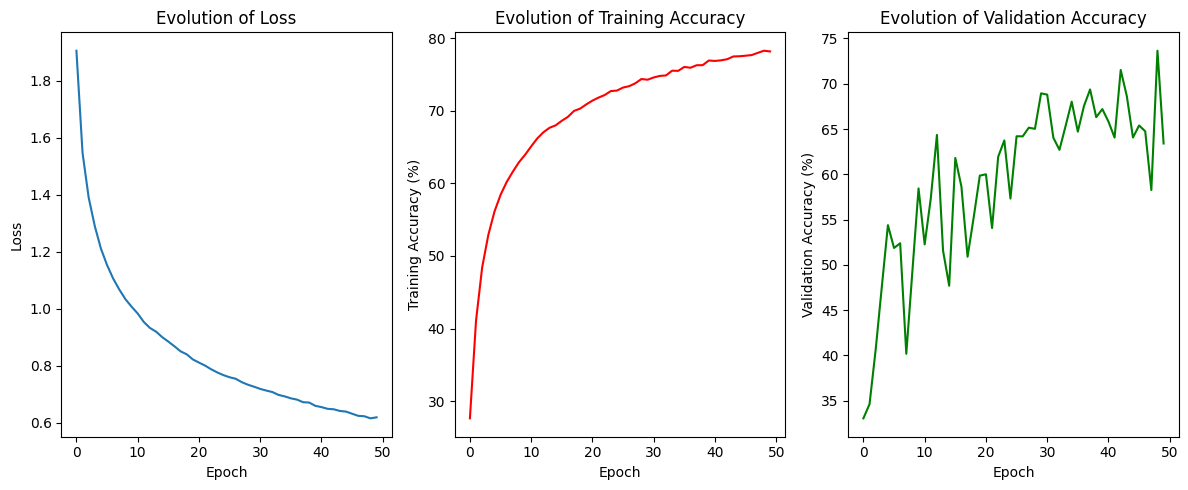

In [68]:
train_plt(model, trainloader, testloader, loss, optimizer, 50)

#5) Final model accuracy on validation set (5%)

In [71]:
# Final model evaluation (Validation Accuracy)

model.eval()  # Setting the model to evaluation mode

test_losses = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disabling gradient computation during evaluation
    for batch_idx, (testX, testY) in enumerate(testloader):
        testX = testX.to(device)  # Move input tensor to the GPU
        testY = testY.to(device)  # Move target tensor to the GPU
        outputs = model(testX)  # Forward pass to obtain model predictions
        _, predicted = outputs.max(1)  # Getting predicted labels
        total += testY.size(0)  # Accumulating total number of samples
        correct += predicted.eq(testY).sum().item()  # Accumulating number of correct predictions

# Computing accuracy
acc = 100.0 * correct / total

print('The final model Validation/Testing accuracy is:  %.3f' % acc)


The final model Validation/Testing accuracy is:  63.400
